# Colony Image processing
##  From stacked tif images to angular and pair correlation metric

In [1]:
using Pkg
Pkg.instantiate()

In [2]:
using Revise, CairoMakie
using ColonyImages
using DataFrames, CSV, FileIO

In [3]:
#using Images, FileIO, BenchmarkTools, CairoMakie, Dates
#using FFTW, Revise, DataFrames, Chain, DataFramesMeta, StatsBase, Serialization, CSV, ColonyImages

#### Create empty data frame to store metrics together with colony ids and age of colony  

In [4]:
df = DataFrame(data_set =String[], colony = String[], time = Int[], 
    metric_OG =Vector{Vector{Int64}}(undef,0), metric_cov = Vector{Vector{Int64}}(undef,0),
    pair_OG =Vector{Vector{Int64}}(undef,0),pair_cov =Vector{Vector{Int64}}(undef,0),OG_size = Int[])

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64


#### Check which data sets are available in data folder

In [5]:
image_data = "data\\image_data_stacked\\"
for (i,x) in enumerate(readdir(image_data))
    println(i,"  ",x)
end

1  10_04_23_stacked_half_res
2  14_06_23_stacked_full_res
3  14_06_23_stacked_half_res
4  17_05_23_stacked_full_res
5  17_05_23_stacked_half_res
6  19_12_22_stacked_full_res
7  26_06_23_stacked_full_res
8  27_04_22_stacked_full_res_expo
9  27_04_22_stacked_half_res_expo
10  28_03_23_stacked_half_res


#### Chose dataset 
Image pipeline has been created for stacked tif images. Image data needs to be in that format for pipeline to work correctly.  

In [6]:
data_set = readdir(image_data)[10]
path = joinpath(image_data, data_set)
readdir(path)

14-element Vector{String}:
 "Kolonie 1.tif"
 "Kolonie 2.tif"
 "Kolonie 3.tif"
 "Kolonie 4.tif"
 "Kolonie 5.tif"
 "Kolonie 6.tif"
 "Kolonie 7.tif"
 "Kolonie 8.tif"
 "angular&pair.png"
 "methos_compare_centroid.png"
 "methos_compare_cov.png"
 "methos_compare_cov_shown.png"
 "show_cov.png"
 "timepoints.csv"

The time series colony images have been take at certain dates/times T(n) (where n is the number of time points). The specific dates can be found in the meta data of the raw tif images. Here only the relative time points are relevant, therefore first images are set to T_r(1) = 0 and the following to the next full hours of T(n)_r = T(n)-T(1). The time points are stored in a `csv` file called `timepoints.csv` next to the image data. If `timepoints.csv` does not exist already, it will be created manually by the cell below. 

In [7]:
if "timepoints.csv" ∉ readdir(path)
    
    df2 = DataFrame(time = Float64[0,20,24,44])
    
    if length(df2.time) != size(load(joinpath.(path, filter(x->x[end-2:end]=="tif",readdir(path)))[1]))[3]
        println("ERROR ERROR ERROR ")
    else
        CSV.write(joinpath(path,"timepoints.csv"), df2)   
    end
else println("df already existing")
end

time_points = CSV.read(joinpath(path,"timepoints.csv"), DataFrame).time

df already existing


4-element Vector{Float64}:
  0.0
  5.0
 24.0
 48.0

All `tif` files inside chosen folder are loaded into img_vec with is a vector of stacked images(3 dimensional (x,y,t) arrays). 

In [8]:
colonies = filter(x->x[end-2:end]=="tif",readdir(path))
img_vec  = load.(joinpath.(path, colonies));

Loading: 100%|███████████████████████████████████████████| Time: 0:00:00


#### Parameters for Image analysis :

`relative_size_filles_holes` defines how big the holes inside a colony can be relative to the image size, that are filled automatically with the `fill_holes` function. 

`threshold_conv`, `threshold_c` and `kernel_ratio` are all parameter of the convolution process, which is explained in more detail below. For typical images they should remain at their default values:
```julia 
threshold_conv = 0.8
threshold_c = 0.8
kernel_ratio = 0.4
```

`Points` is a vector of vectors of `Lattice vectors` in ascending order by their length . Whereas the first entry of `Points` contains a vector of all lattice vectors which lengths are lower than 2:
```julia
Points[1] = [[0, 1], [0, 1], [0, -1], [0, -1], [1, 0], [-1, 0], [1, 0], [-1, 0], [1, 1], [-1, 1], [1, -1], [-1, -1]]
```
`Points[2]` does the same for length lower than 3:
```julia
Points[2] = [[0, 2], [0, 2], [0, -2], [0, -2], [2, 0], [-2, 0], [2, 0], [-2, 0], [1, 2], [-1, 2], [1, -2], [-1, -2], [2, 1], [-2, 1], [2, -1], [-2, -1], [2, 2], [-2, 2], [2, -2], [-2, -2]]
```
and so on...
The `Points` vectors is latter needed to fit a circle onto the reduced colony. 


`steps_angular` defines the number of steps in the angular metric around a unit circle. For its default value 
```julia
steps_angular = 360
```
every steps is 1° degree wide. 

`samples_pair` defines how many random pair of lattice points are sampled for the pair correlation metric. A higher number here is always better for the precision. The only limiting factor here is computation time (and at some point probably memory). Its default values is: 

```julia
samples_pair = 2000000
```


In [9]:
# automatically inverts and converts images to black and white (binary) if not already 
img_int_vec = b_w.(img_vec);
# 
relative_size_filles_holes = 0.01
img_int_vec = fill_holes.(img_int_vec,[relative_size_filles_holes for x in length(img_int_vec)]);
# threshold_conv has to be lowered for not homogenoulsy filled colonies
threshold_conv = 0.8
threshold_c = 0.8
# kernel ratio is given against approximate site of colony calculated by occupied points
kernel_ratio = 0.4
Points = lattice_points(maximum(maximum.(size.(img_int_vec)))÷2);
steps_angular = 360

# the more the better, only limited by computation time
samples_pair = 2000000;


### Convolution explanation 

In [10]:
colony_to_show = 5
res= (2100,500)

(2100, 500)

In [11]:
int_img = img_int_vec[colony_to_show][:,:,end]
y1,x1 = centroid(int_img)
kernel = create_kernel(round(Int64,approx_radi_colo(img_int_vec[5][:,:,1])*kernel_ratio), geometry = "square")
nneigh = sum(kernel)
out = conv(int_img, kernel ) ./ nneigh;

In [12]:
img_int_vec[2][:,:,1]

750×690 BitMatrix:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 ⋮              ⋮              ⋮        ⋱        ⋮              ⋮           
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  

In [13]:
abs(-2)

2

In [14]:
fig = Figure(size =(2000,2000))
ax = Axis(fig[1,1], aspect = DataAspect(), xlabel = "x", ylabel = "y")
heatmap!(ax,abs.(img_int_vec[2][:,:,3].-img_int_vec[2][:,:,1]),colormap = :grays)
fig
save("plots/19_hours.png",fig)

CairoMakie.Screen{IMAGE}


In [15]:
fig = Figure(size =(2000,2000))
ax = Axis(fig[1,1], aspect = DataAspect(), xlabel = "x", ylabel = "y")
heatmap!(ax,abs.(img_int_vec[2][:,:,end].-img_int_vec[2][:,:,1]),colormap = :grays)
fig
save("plots/48_hours.png",fig)

CairoMakie.Screen{IMAGE}


In [16]:
fontsize_theme = Theme(fontsize = 40)
update_theme!(fontsize_theme)

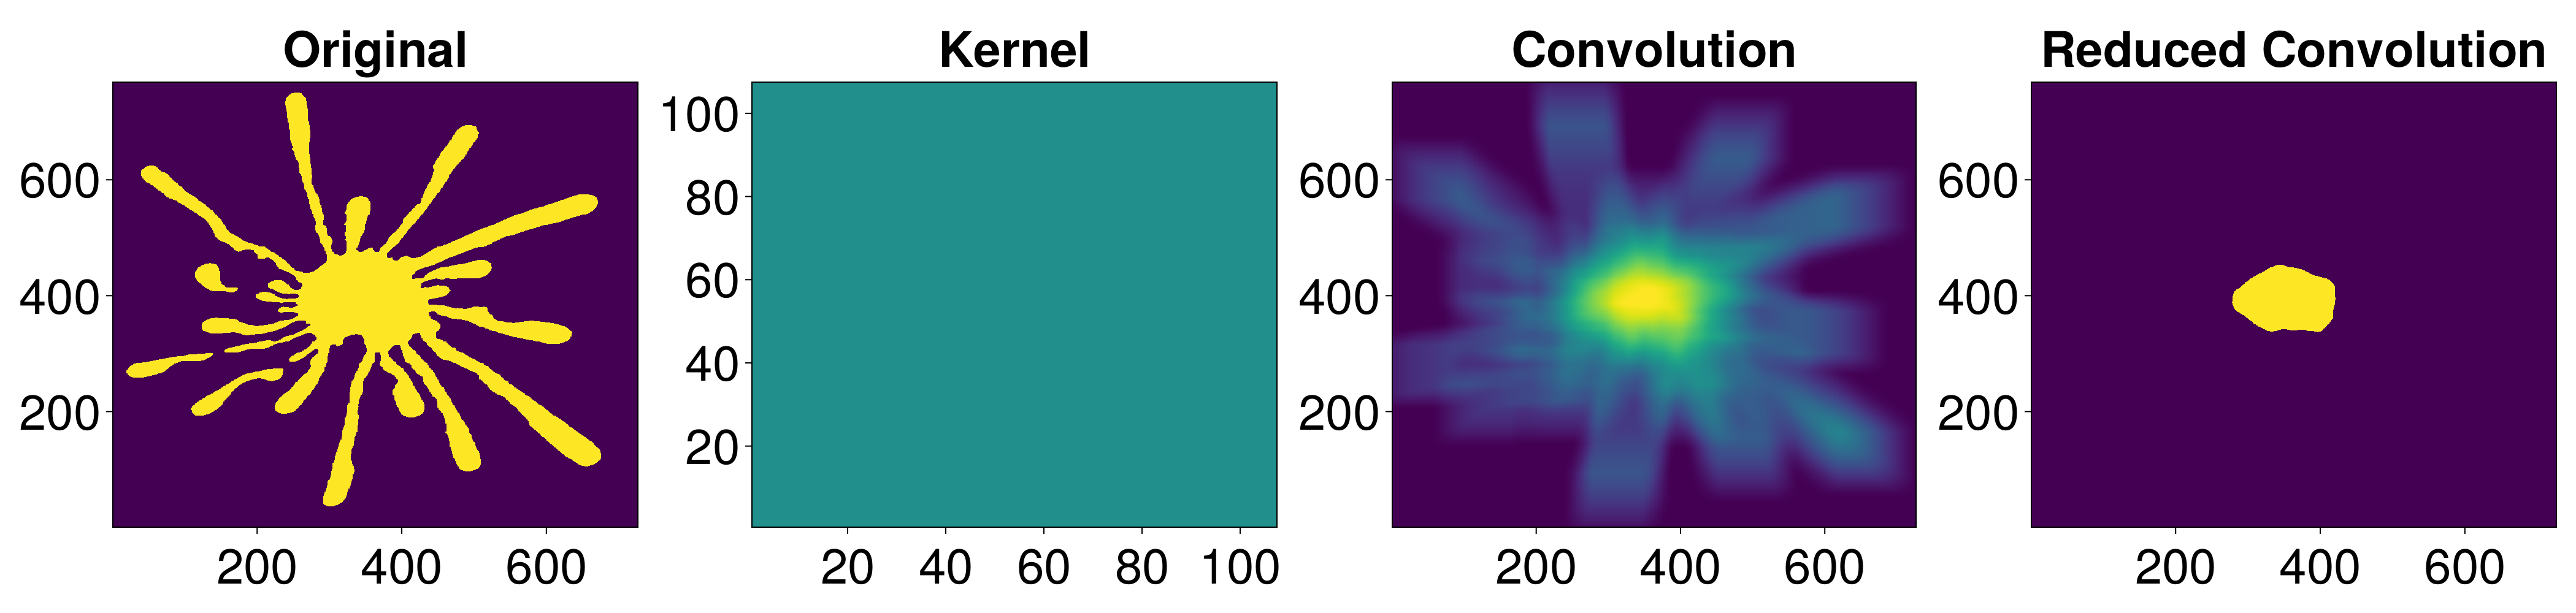

In [17]:
comp_conv = Figure(size = res)
ax_1 = CairoMakie.Axis(comp_conv[1,1], title = "Original")
heatmap!(ax_1, int_img)
ax_2 = CairoMakie.Axis(comp_conv[1,2], title = "Kernel")
heatmap!(ax_2, kernel)
ax_3 = CairoMakie.Axis(comp_conv[1,3], title = "Convolution")
heatmap!(ax_3, out)
ax_4 = CairoMakie.Axis(comp_conv[1,4], title = "Reduced Convolution")
heatmap!(ax_4, out.>threshold_conv)


save(joinpath("plots","convolution.png"), comp_conv)

comp_conv

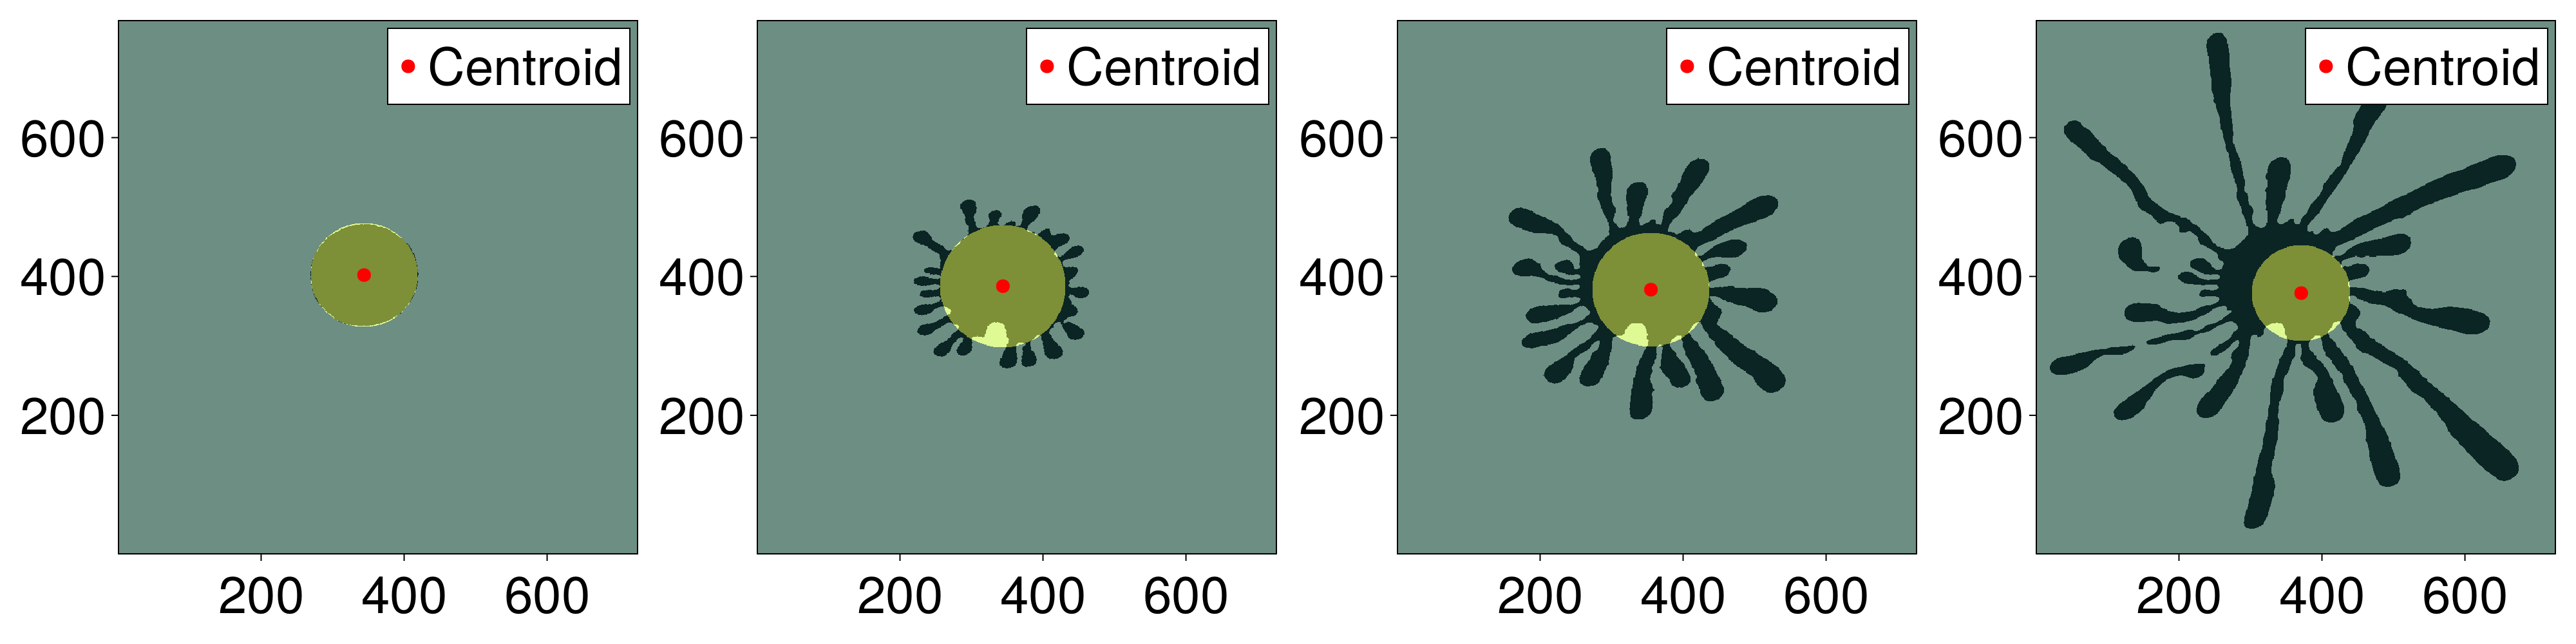

In [18]:
fig_big = Figure(size = (2000,500))

c = 0 

img_stack = img_int_vec[colony_to_show]
int_img = img_stack[:,:,1]
y1,x1 = centroid(int_img)
kernel = create_kernel(round(Int64,approx_radi_colo(int_img)*kernel_ratio), geometry = "square")
nneigh = sum(kernel)

for z in 1:size(img_stack,3)
    int_img = img_stack[:,:,z]
    out = conv( int_img, kernel ) ./ nneigh
    y_c, x_c = centroid(out .> threshold_conv)
    y,x = centroid(int_img)
    ax = CairoMakie.Axis(fig_big[c÷5+1,c%5+1])
    #hidedecorations!(ax)
    circle_kernel = build_circle([y,x],int_img,Points,threshold = 0.8)
    heatmap!(ax,int_img,colormap = :algae)
    #heatmap!(ax,out .> threshold_conv, colormap  =(:algae, 0.2))
    heatmap!(ax,circle_kernel, colormap  =(:thermal, 0.5))
    #scatter!(ax,y1,x1, color = :blue, markersize = 15, label = "Centroid first Timestep")
    
    scatter!(ax,y,x, color = :red, markersize = 15, label = "Centroid")
    #scatter!(ax,y_c, x_c, color = :yellow, markersize = 15, label = "Centroid convoluted")
    axislegend(ax)
    c += 1
        
end



save(joinpath("plots","normal_centroid.png"), fig_big)

fig_big

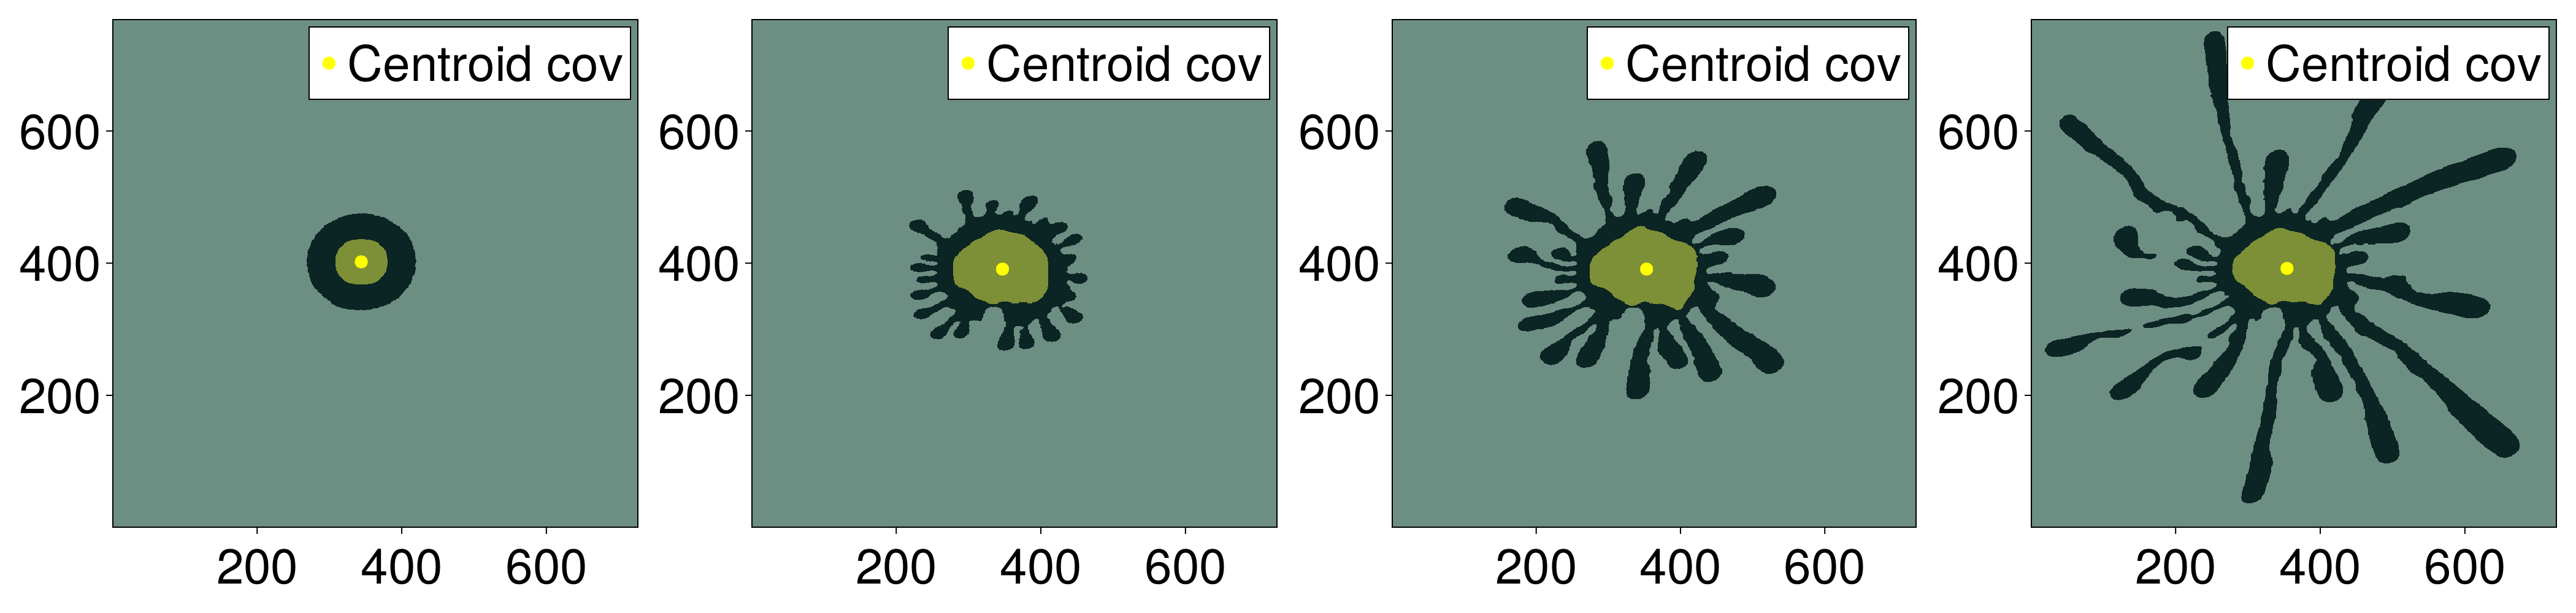

In [19]:
fig_big = Figure(size = res)

c = 0 

img_stack = img_int_vec[colony_to_show]
int_img = img_stack[:,:,1]
y1,x1 = centroid(int_img)
kernel = create_kernel(round(Int64,approx_radi_colo(int_img)*kernel_ratio), geometry = "square")
nneigh = sum(kernel)


for z in 1:size(img_stack,3)
    int_img = img_stack[:,:,z]
    out = conv( int_img, kernel ) ./ nneigh
    y_c, x_c = centroid(out .> threshold_conv)
    y,x = centroid(int_img)
    ax = CairoMakie.Axis(fig_big[c÷5+1,c%5+1])
    #hidedecorations!(ax)
    heatmap!(ax,int_img,colormap = :algae)
    heatmap!(ax,out .> threshold_conv, colormap  =(:thermal, 0.5))
    #scatter!(ax,y1,x1, color = :blue, markersize = 15, label = "Centroid first Timestep")
    
    #scatter!(ax,y,x, color = :red, markersize = 15, label = "Centroid")
    scatter!(ax,y_c, x_c, color = :yellow, markersize = 15, label = "Centroid cov")
    axislegend(ax)
    c += 1
        
end



save(joinpath("plots","cov_centroid.png"), fig_big)

fig_big

In [ ]:
fig_big = Figure(size = res)

c = 0 

img_stack = img_int_vec[colony_to_show]
int_img = img_stack[:,:,1]
y1,x1 = centroid(int_img)
kernel = create_kernel(round(Int64,approx_radi_colo(int_img)*kernel_ratio), geometry = "square")
nneigh = sum(kernel)
    
for z in 1:size(img_stack,3)
    int_img = img_stack[:,:,z]
    out = conv( int_img, kernel ) ./ nneigh
    y_c, x_c = centroid(out .> threshold_conv)
    y,x = centroid(int_img)
    ax = CairoMakie.Axis(fig_big[c÷5+1,c%5+1])
    #hidedecorations!(ax)
    circle_kernel = build_circle([y_c, x_c],int_img,Points,threshold = 0.8)
    heatmap!(ax,int_img,colormap = :algae)
    #heatmap!(ax,out .> threshold_conv, colormap  =(:algae, 0.2))
    heatmap!(ax,circle_kernel, colormap  =(:thermal, 0.5))
    #scatter!(ax,y1,x1, color = :blue, markersize = 15, label = "Centroid first Timestep")
    
    #scatter!(ax,y,x, color = :red, markersize = 15, label = "Centroid")
    scatter!(ax,y_c, x_c, color = :yellow, markersize = 15, label = "Centroid cov")
    axislegend(ax)
    c += 1
        
end



#save(joinpath("plots","cov_normal_centroid_compare.png"), fig_big)

fig_big


In [78]:
a = 1
fig_big = Figure(size = res_scaling(img_int_vec, factor =3, plots = 3))
c = 0 

for (i,img_stack) in enumerate(img_int_vec)
    int_img = img_stack[:,:,1]
    y1,x1 = centroid(int_img)
    kernel = create_kernel(round(Int64,approx_radi_colo(int_img)*kernel_ratio), geometry = "square")
    nneigh = sum(kernel)
    
    for z in 1:size(img_stack,3)
        int_img = img_stack[:,:,z]
        out = conv( int_img, kernel ) ./ nneigh
        y_c, x_c = centroid(out .> threshold_conv)
        ang_mec_og = angular_metric(int_img .- img_stack[:,:,1],[y1,x1], steps = steps_angular)
        pair_mec_og = pair_cor_metric3(z == 1 ? int_img : int_img .- img_stack[:,:,1],[y1,x1], steps = steps_angular,samples = samples_pair)
        
        fitted_circle = build_circle([y_c, x_c], int_img, Points, threshold = threshold_c)
        ang_mec_conv = angular_metric(z == 1 ? int_img : int_img .- fitted_circle , [y1,x1], steps = steps_angular )
        
        pair_mec_conv = pair_cor_metric3(z == 1 ? int_img : int_img.- fitted_circle, [y_c, x_c], steps = steps_angular,samples = samples_pair )
        
        ax = CairoMakie.Axis(fig_big[c÷5+1,(c%5+1)*3-2], title = colonies[i])
        heatmap!(ax,int_img,colormap = :algae)
        #heatmap!(ax,out .> threshold_conv, colormap  =(:algae, 0.2))
        scatter!(ax,y1,x1, color = :blue, markersize = 10, label = "first centroid")
        scatter!(ax,y_c, x_c, color = :yellow, markersize = 10, label = "Convolut centroid")
        axislegend(ax)
        
        ax2 = CairoMakie.Axis(fig_big[c÷5+1,(c%5+1)*3-1], title = colonies[i])
        lines!(ax2,ang_mec_og, label = "OG angular metric" )
        
        ax3 = CairoMakie.Axis(fig_big[c÷5+1,(c%5+1)*3], title = colonies[i])
        lines!(ax3,pair_mec_og, label = "OG pair metric" )
        # convoluted angular metrix does not make sense for colony without expansion 
        if z != 1
            lines!(ax2,ang_mec_conv, label = "conv angular metric" )
            lines!(ax3,pair_mec_conv, label = "conv pair metric" )
        end
        axislegend(ax2)
        axislegend(ax3)
        push!(df,[data_set,colonies[i],time_points[z],ang_mec_og,ang_mec_conv,pair_mec_og,pair_mec_conv,sum(img_stack[:,:,1])])
        c += 1
             
    end

end

#save(joinpath(path,"angular&pair.png"), fig_big)
fig_big

# Make angular metric Shematic 

df already existing


┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\Andreas\.julia\packages\Makie\fyNiH\src\scenes.jl:220


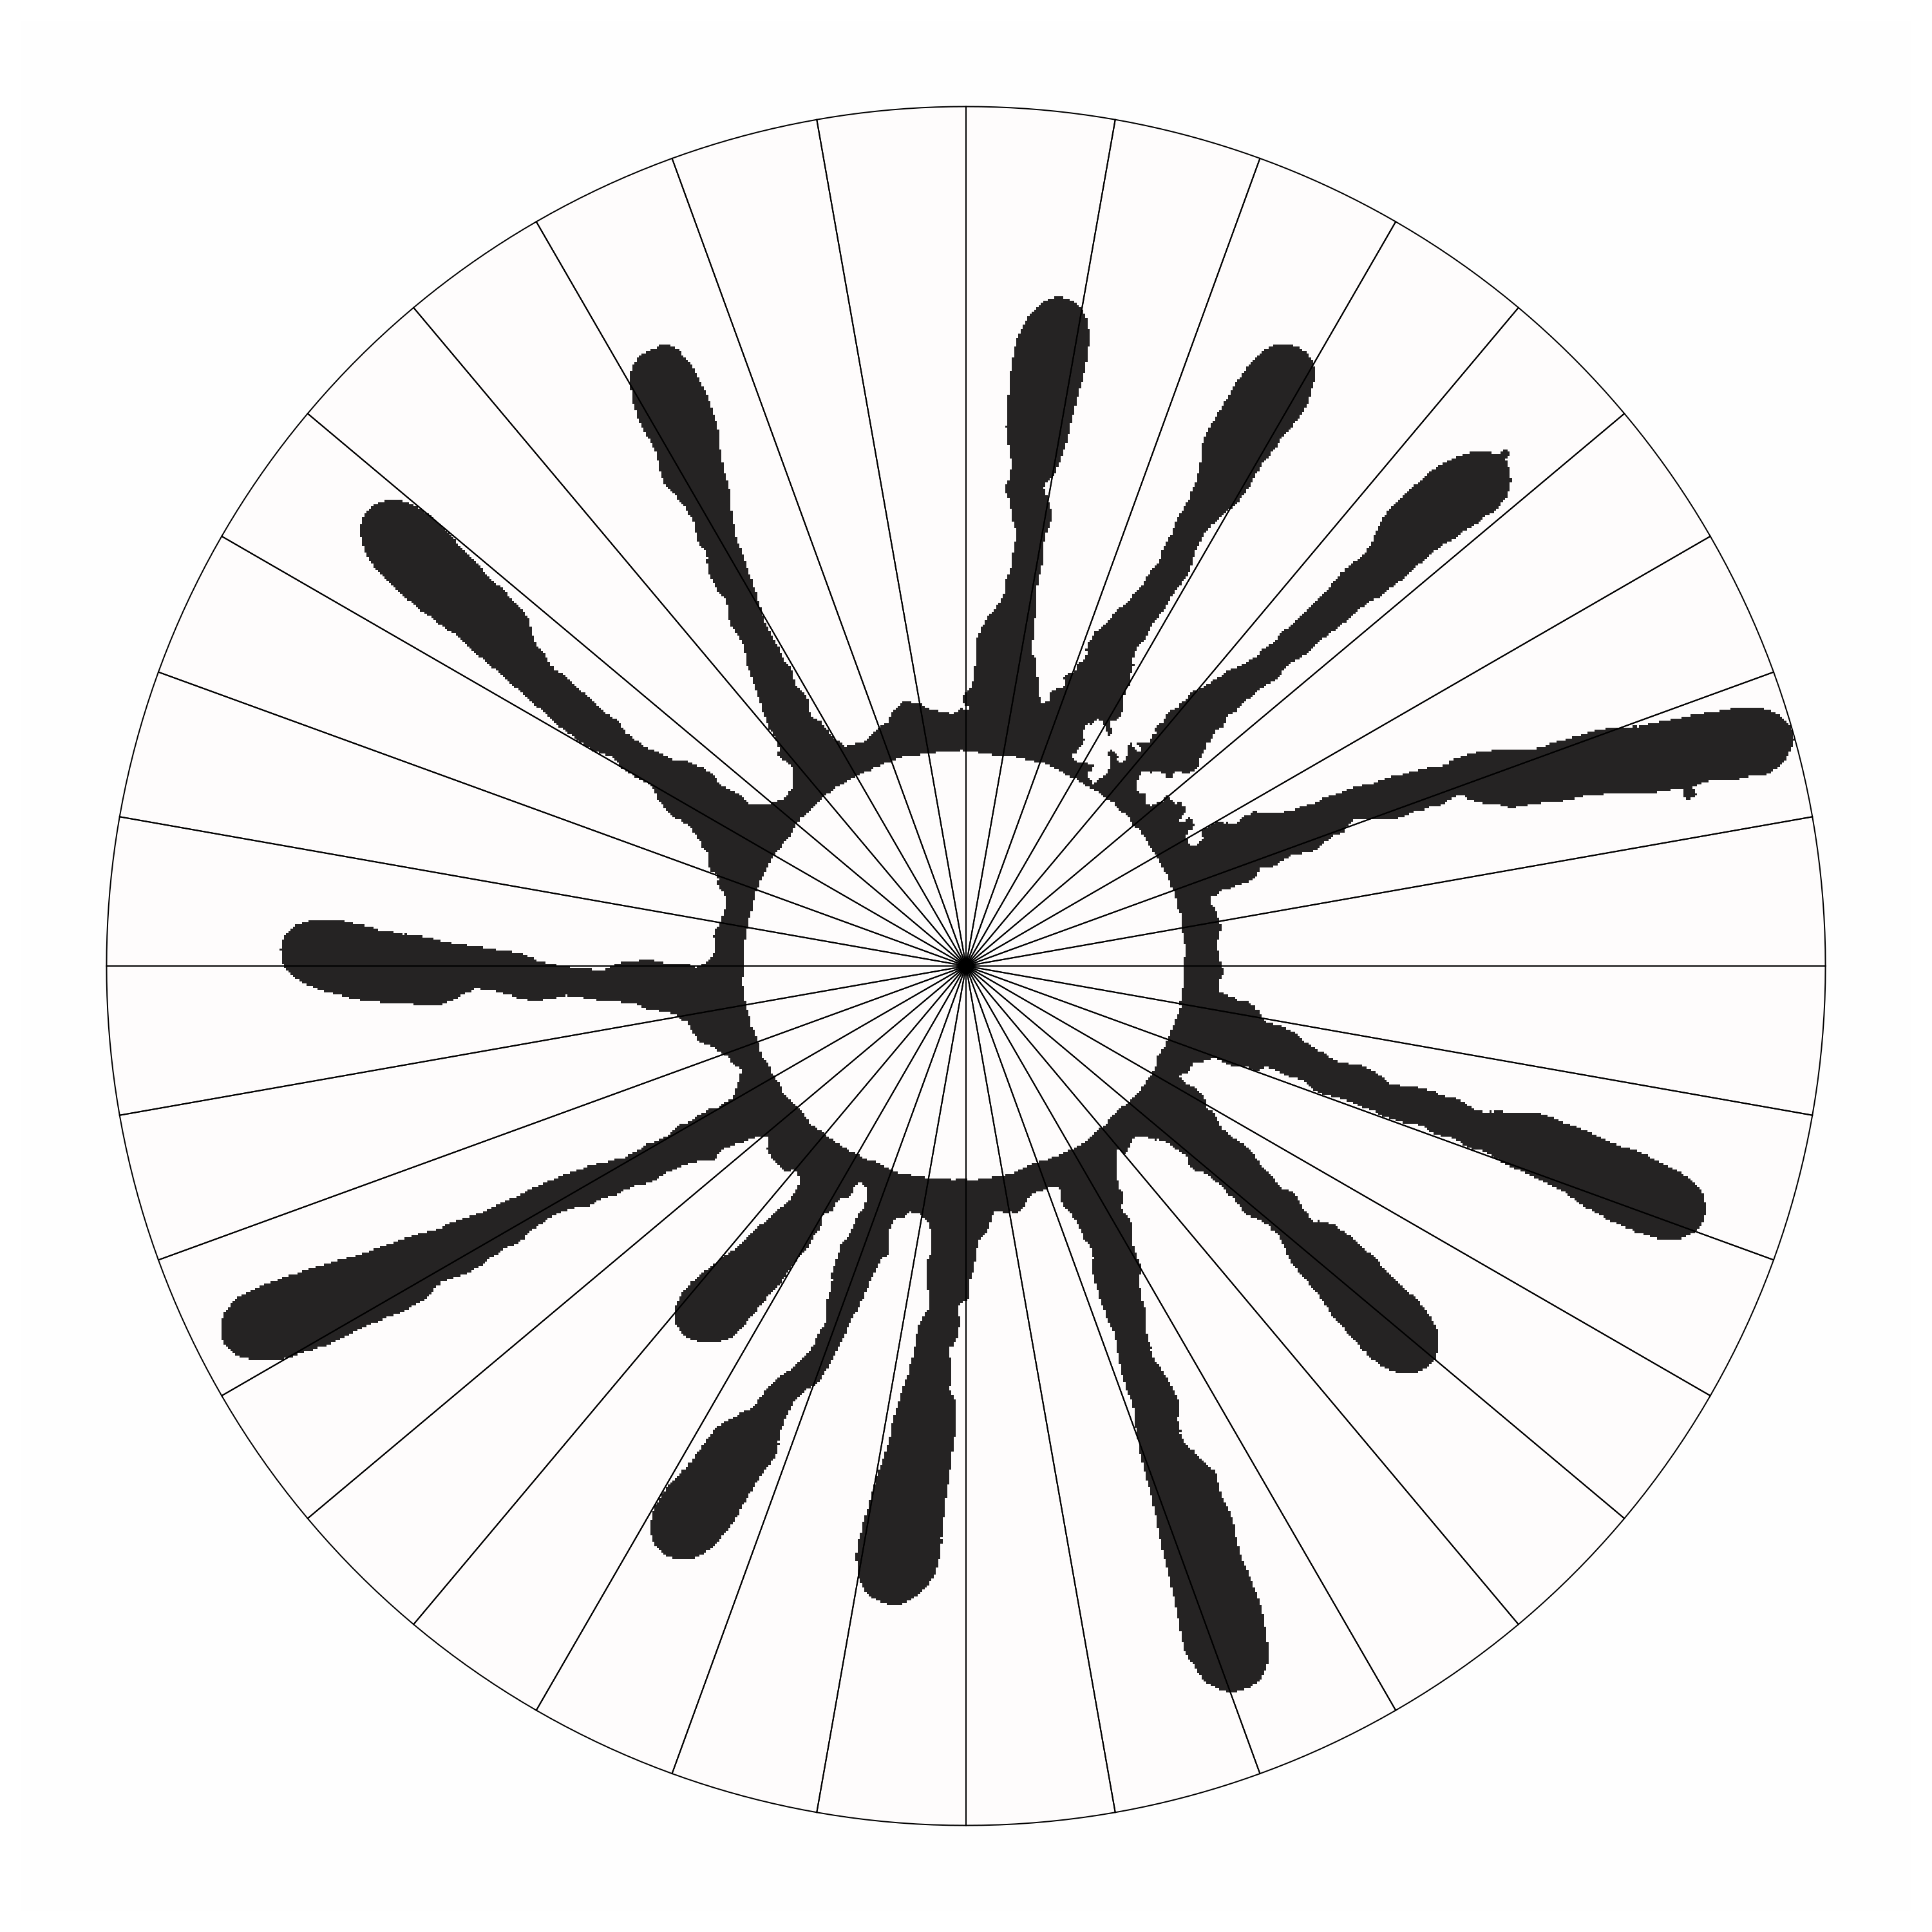

In [20]:
path = joinpath(image_data, "26_06_23_stacked_full_res")
readdir(path)


if "timepoints.csv" ∉ readdir(path)
    
    df2 = DataFrame(time = Float64[0,20,24,44])
    
    if length(df2.time) != size(load(joinpath.(path, filter(x->x[end-2:end]=="tif",readdir(path)))[1]))[3]
        println("ERROR ERROR ERROR ")
    else
        CSV.write(joinpath(path,"timepoints.csv"), df2)   
    end
else println("df already existing")
end

time_points = CSV.read(joinpath(path,"timepoints.csv"), DataFrame).time

colonies = filter(x->x[end-2:end]=="tif",readdir(path))
img_vec  = load.(joinpath.(path, colonies));


# automatically inverts and converts images to black and white (binary) if not already 
img_int_vec = b_w.(img_vec);
# 
relative_size_filles_holes = 0.01
img_int_vec = fill_holes.(img_int_vec,[relative_size_filles_holes for x in length(img_int_vec)]);
# threshold_conv has to be lowered for not homogenoulsy filled colonies
threshold_conv = 0.8
threshold_c = 0.8
# kernel ratio is given against approximate site of colony calculated by occupied points
kernel_ratio = 0.4
Points = lattice_points(maximum(maximum.(size.(img_int_vec)))÷2);
steps_angular = 360

# the more the better, only limited by computation time
samples_pair = 2000000;



fig_89 = Figure(resolution =(1500,round(Int,1500)))
int_img = img_int_vec[7][:,:,1]
y1,x1 = centroid(int_img)
kernel = create_kernel(round(Int64,approx_radi_colo(int_img)*kernel_ratio), geometry = "square")
nneigh = sum(kernel)

int_img = img_int_vec[2][:,:,6]
#int_img = hcat(int_img[1:end-18,70:end],zeros(Int,1812-18,24))
#int_img = expand_matrix(int_img, annuli= 70)
int_img = rotr90(int_img)
x = 420
y_o = 150
x_o = -3


int_img = int_img[(x-x_o):end-(x+x_o),(x-y_o):end-(x+y_o) ]
int_fac = round(Int,(1-0.8705035971223022)*size(int_img)[1]/2)

int_img = int_img[:,int_fac: end-int_fac]
out = conv( int_img, kernel ) ./ nneigh
y_c, x_c = centroid(out .> threshold_conv)
y,x = centroid(int_img)
ax = CairoMakie.Axis(fig_89[1,1])
ax2 = CairoMakie.Axis(fig_89[1,1])
hidedecorations!(ax2)
hidedecorations!(ax)

hidespines!(ax)
hidespines!(ax2)

circle_kernel = build_circle([y_c, x_c],int_img,Points,threshold = 0.8)
#heatmap!(ax,int_img,colormap = (:hawaii,1.0))
#heatmap!(ax,out .> threshold_conv, colormap  =(:algae, 0.2))
#heatmap!(ax,circle_kernel, colormap  =(:thermal, 0.5))

int_img_1 = img_int_vec[2][:,:,1]
#int_img = hcat(int_img[1:end-18,70:end],zeros(Int,1812-18,24))
#int_img = expand_matrix(int_img, annuli= 70)
int_img_1 = rotr90(int_img_1)
x = 420
y_o = 150
x_o = -3
int_img_1 = int_img_1[(x-x_o):end-(x+x_o),(x-y_o):end-(x+y_o) ]

int_fac = round(Int,(1-0.8705035971223022)*size(int_img_1)[1]/2)

int_img_1 = int_img_1[:,int_fac: end-int_fac]

#heatmap!(ax,int_img,colormap = (:grayC10,1.0))

heatmap!(ax,(int_img.-int_img_1).*-1,colormap = (:grayC10,1.0))
#heatmap!(ax,int_img_1, colormap  =(:thermal, 0.5))
#scatter!(ax,y1,x1, color = :blue, markersize = 15, label = "Centroid first Timestep")

#scatter!(ax,y,x, color = :red, markersize = 15, label = "Centroid")
#scatter!(ax,y_c, x_c, color = :black, markersize = 45, label = "Centroid")
pie_data = [1 for i in 1:10:360]
pie!(ax2,pie_data,radius = 10, color = (:red, 0.01))
#axislegend(ax)
fig_89

### Calculate the angular correlation function once with the convoluted centroid and fitted circle and second with the OG colone as mask 

#### Save data into .jls file to analyse further in seperate notebook

In [19]:
df

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size
,String,String,Int64,Array…,Array…,Array…,Array…,Int64
1,28_03_23_stacked_half_res,Kolonie 1.tif,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[50, 31, 41, 42, 42, 41, 41, 41, 42, 46 … 39, 46, 41, 41, 41, 41, 42, 41, 40, 50]","[5560, 5568, 5631, 5512, 5594, 5610, 5528, 5636, 5553, 5556 … 5595, 5582, 5635, 5569, 5576, 5637, 5605, 5504, 5421, 5528]","[5552, 5427, 5531, 5445, 5556, 5520, 5475, 5478, 5473, 5465 … 5505, 5560, 5653, 5768, 5583, 5638, 5577, 5628, 5337, 5622]",15080
2,28_03_23_stacked_half_res,Kolonie 1.tif,5,"[17, 21, 20, 13, 18, 17, 17, 35, 46, 49 … 8, 10, 11, 12, 11, 13, 12, 13, 21, 17]","[6, 8, 3, 3, 4, 2, 3, 19, 33, 35 … 5, 4, 3, 4, 3, 2, 2, 2, 3, 6]","[7350, 7662, 7380, 7152, 6844, 6517, 6326, 5991, 5701, 5554 … 5273, 5172, 5330, 5353, 5341, 5370, 5207, 5234, 5256, 5233]","[10658, 10759, 10175, 9422, 8757, 8026, 7326, 6631, 5719, 5166 … 5567, 5592, 5170, 5194, 5091, 4949, 4733, 4613, 4818, 4459]",15080
3,28_03_23_stacked_half_res,Kolonie 1.tif,24,"[17, 23, 22, 19, 22, 58, 152, 187, 201, 206 … 7, 7, 7, 8, 9, 11, 9, 9, 17, 17]","[7, 12, 6, 10, 10, 44, 140, 172, 189, 193 … 5, 3, 4, 5, 2, 2, 2, 1, 0, 7]","[9575, 9330, 9064, 9050, 8507, 8127, 7806, 7375, 6706, 6666 … 5606, 5399, 5304, 5115, 5155, 5092, 5251, 5144, 5016, 4892]","[11221, 10846, 10611, 9982, 9582, 9070, 8877, 8175, 7319, 6898 … 5251, 5077, 5082, 5033, 4871, 4821, 4672, 4568, 4702, 4664]",15080
4,28_03_23_stacked_half_res,Kolonie 1.tif,48,"[16, 24, 23, 21, 23, 46, 184, 424, 589, 683 … 7, 8, 8, 8, 8, 10, 8, 9, 18, 16]","[9, 17, 9, 14, 15, 34, 174, 413, 579, 673 … 0, 0, 2, 1, 1, 1, 0, 1, 3, 9]","[12361, 11860, 11516, 10978, 10367, 9633, 8793, 8285, 7526, 6738 … 4919, 4788, 4772, 4564, 4365, 4558, 4552, 4530, 4416, 4468]","[13507, 13408, 12673, 11970, 11187, 10628, 9692, 8939, 7863, 7040 … 4982, 4787, 4519, 4355, 4164, 4026, 4055, 3788, 3816, 3770]",15080
5,28_03_23_stacked_half_res,Kolonie 2.tif,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[50, 31, 41, 42, 43, 42, 42, 43, 43, 47 … 39, 46, 42, 41, 41, 42, 43, 42, 41, 50]","[5352, 5634, 5664, 5523, 5551, 5519, 5521, 5647, 5551, 5482 … 5523, 5578, 5629, 5435, 5445, 5596, 5589, 5635, 5660, 5639]","[5481, 5359, 5505, 5594, 5603, 5459, 5529, 5523, 5655, 5618 … 5484, 5555, 5449, 5483, 5597, 5568, 5455, 5538, 5552, 5651]",15551
6,28_03_23_stacked_half_res,Kolonie 2.tif,5,"[61, 79, 67, 56, 49, 46, 42, 41, 62, 86 … 31, 31, 33, 39, 46, 52, 58, 61, 70, 61]","[24, 32, 28, 19, 9, 7, 2, 1, 22, 46 … 5, 7, 4, 2, 6, 15, 19, 24, 31, 24]","[6475, 6741, 6453, 6592, 6306, 6174, 6167, 6099, 5952, 5909 … 4972, 5029, 4991, 4908, 4946, 4918, 5002, 4833, 4848, 4959]","[7405, 7894, 7527, 7221, 6817, 6376, 6273, 5938, 5810, 5595 … 5635, 5627, 5717, 5861, 5848, 5945, 6070, 6001, 5943, 5907]",15551
7,28_03_23_stacked_half_res,Kolonie 2.tif,24,"[86, 98, 85, 75, 64, 56, 82, 99, 124, 138 … 38, 38, 38, 45, 69, 78, 83, 84, 91, 86]","[36, 33, 28, 22, 9, 9, 38, 59, 74, 81 … 10, 12, 11, 7, 15, 27, 32, 34, 36, 36]","[9117, 8792, 9052, 8754, 8532, 8550, 7913, 7831, 7556, 7190 … 5118, 5170, 4928, 4983, 4927, 4808, 4905, 4787, 4736, 4771]","[13018, 13035, 12533, 12279, 11620, 11077, 10998, 10366, 9725, 8964 … 4773, 4692, 4539, 4508, 4503, 4404, 4250, 4363, 4310, 4403]",15551
8,28_03_23_stacked_half_res,Kolonie 2.tif,48,"[660, 162, 118, 92, 57, 44, 42, 43, 36, 33 … 78, 228, 380, 723, 916, 965, 988, 992, 979, 660]","[636, 133, 92, 66, 33, 16, 15, 16, 12, 12 … 57, 206, 359, 699, 892, 942, 966, 970, 954, 636]","[13233, 13133, 12481, 12219, 11527, 11001, 10539, 9634, 9120, 8402 … 4973, 4709, 4523, 4306, 4291, 4289, 4012, 4063, 4151, 3994]","[17810, 17502, 16930, 15949, 15047, 14173, 13158, 12100, 10871, 9847 … 4645, 4639, 4642, 4629, 4667, 4590, 4555, 4610, 4449, 4584]",15551
9,28_03_23_stacked_half_res,Kolonie 3.tif,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[55, 36, 51, 47, 48, 48, 48, 48, 47, 53 … 44, 53, 47, 48, 4